In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
    
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from pydrake.geometry.optimization import HPolyhedron
from pydrake.geometry.optimization import CartesianProduct
from pydrake.solvers import MosekSolver
from pydrake.trajectories import PiecewisePolynomial

from gcs.bezier import BezierGCS
from gcs.linear import LinearGCS
from gcs.rounding import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# some helper functions for plotting cuboids
# https://stackoverflow.com/questions/49277753/plotting-cuboids
def edgecoord(pointx,pointy,pointz):
    edgex=[pointx[0],pointx[1],pointx[1],pointx[0]]
    edgey=[pointy[0],pointy[1],pointy[1],pointy[0]]
    edgez=[pointz[0],pointz[0],pointz[1],pointz[1]]
    return list(zip(edgex,edgey,edgez))

def coordConvert(x,y,lheight,uheight):
    if len(x) != len(y) and len(x)>2:
        return
    vertices=[]
    #Top layer
    vertices.append(list(zip(x,y,list(np.full(len(x),uheight)))))
    # Side layers
    for it in np.arange(len(x)):
        it1=it+1
        if it1>=len(x):
            it1=0
        vertices.append(edgecoord([x[it],x[it1]],[y[it],y[it1]],[lheight,uheight]))
    #Bottom layer
    vertices.append(list(zip(x,y,list(np.full(len(x),lheight)))))
    #print(vertices)
    print(np.array(vertices))
    return vertices

[[[5 0 4]
  [6 0 4]
  [6 8 4]
  [5 8 4]]

 [[5 0 0]
  [6 0 0]
  [6 0 4]
  [5 0 4]]

 [[6 0 0]
  [6 8 0]
  [6 8 4]
  [6 0 4]]

 [[6 8 0]
  [5 8 0]
  [5 8 4]
  [6 8 4]]

 [[5 8 0]
  [5 0 0]
  [5 0 4]
  [5 8 4]]

 [[5 0 0]
  [6 0 0]
  [6 8 0]
  [5 8 0]]]


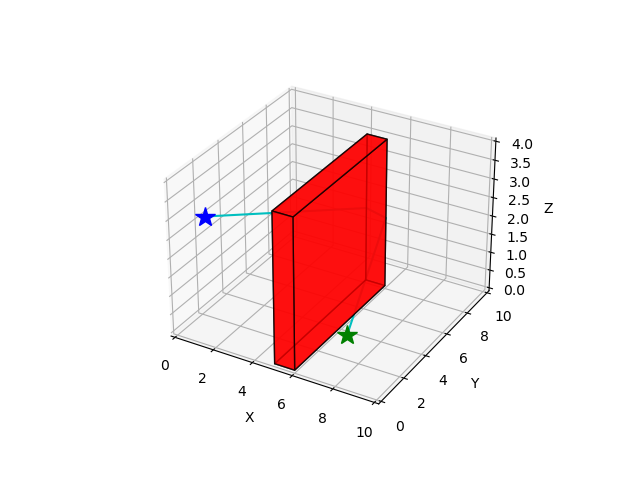

In [24]:
x_start = np.array([1., 1., 3.])
x_goal = np.array([8., 1., 1.])
convex_relaxation = True

A = np.array([[-1, 0, 0], 
              [0, -1, 0], 
              [1, 0, 0],
              [0, 1, 0], 
              [0, 0, -1], 
              [0, 0, 1]])


b_red = np.array([0, 0, 5, 10, 0, 4])
b_green = np.array([0, -8, 10, 10, 0, 4])
b_yellow = np.array([-6, 0, 10, 10, 0, 4])

regions = [
    HPolyhedron(A, b_red),
    HPolyhedron(A, b_green),
    HPolyhedron(A, b_yellow),
]


fig = plt.figure()  
ax = fig.add_subplot(111, projection='3d')  
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_zlim(0, 4)

b_gcs = BezierGCS(regions, order=5, continuity=2)
b_gcs.addTimeCost(1)
b_gcs.addPathLengthCost(1)
b_gcs.addSourceTarget(x_start, x_goal)
b_gcs.setSolver(MosekSolver())
bezier_traj = b_gcs.SolvePath(convex_relaxation)[0]

samples = np.linspace(bezier_traj.start_time(), bezier_traj.end_time())
values = np.squeeze([bezier_traj.value(s) for s in samples])
plt.plot(values[:, 0], values[:, 1],  values[:, 2], "c-")

# plot start and end points
plt.plot(x_start[0], x_start[1], x_start[2], 'b*', markersize=15)
plt.plot(x_goal[0], x_goal[1], x_goal[2], 'g*', markersize=15)

#input values
x=[5, 6, 6, 5]
y=[0, 0, 8, 8]
z=[0,4]

vec=coordConvert(x,y,z[0],z[1])

plt.gca().add_collection3d(Poly3DCollection(vec, alpha=.75,edgecolor='k', facecolor='red'))
